In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

# PPO-Clip Algorithm for Discrete Action Space

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.net(x)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
class PPO:
    """ PPO-Clip Algorithm """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 actor_lr,
                 critic_lr,
                 lmbda,
                 epochs,
                 eps,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs # number of training rounds using one episode data
        self.eps = eps # PPO clip parameter
        self.device = device

        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (~dones.bool()).float()
        td_error = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage

            actor_loss = -torch.mean(torch.min(surr1, surr2))
            critic_loss = F.mse_loss(self.critic(states), td_target.detach())

            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [9]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [10]:

agent = PPO(state_dim,
            hidden_dim,
            action_dim,
            actor_lr,
            critic_lr,
            lmbda,
            epochs,
            eps,
            gamma,
            device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 50/50 [00:02<00:00, 17.13it/s, episode=500, return=200.000]


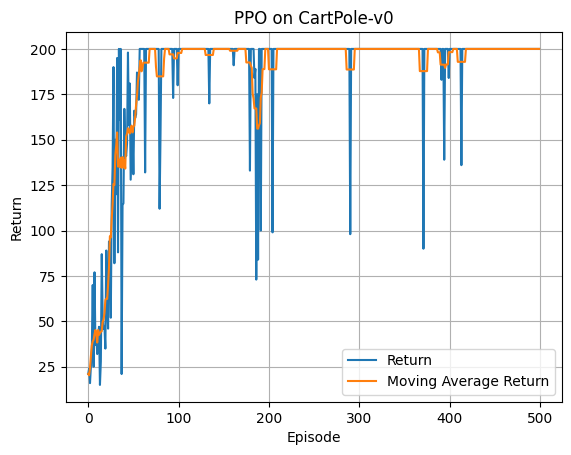

In [11]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [12]:
rl_utils.watch_agent(env_name, agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [13]:
score = rl_utils.moving_average_score(return_list, 10)
print(score)

200.0


In [14]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='ppo_cartpole(v0)_r1',
                                  score=score)

rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='ppo_cartpole(v0)_r10',
                                  score=score)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building file ./video/ppo_cartpole(v0)_r1_score200.00_20250501-044621.gif with imageio.


✅ Video saved at ./video/ppo_cartpole(v0)_r1_score200.00_20250501-044621.gif
MoviePy - Building file ./video/ppo_cartpole(v0)_r10_score200.00_20250501-044624.gif with imageio.


✅ Video saved at ./video/ppo_cartpole(v0)_r10_score200.00_20250501-044624.gif


In [ ]:
agent_dict = {
    'actor': agent.actor,
    'critic': agent.critic
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='ppo_cartpole(v0)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/ppo_cartpole(v0)_score200.00_20250501-044913.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/ppo_cartpole(v0)_score200.00_20250501-044913_return_list.pkl
📈 Return curve saved at ./results/ppo_cartpole(v0)_score200.00_20250501-044913_return_curve.png


# PPO-Clip Algorithm for Continuous Action Space

In [5]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [6]:
class PPOContinuous:
    """ PPO-Clip Algorithm for continuous action space """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 actor_lr,
                 critic_lr,
                 lmbda,
                 epochs,
                 eps,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]
    
    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        rewards = (rewards + 8.0) / 8.0
        td_target = rewards + self.gamma * self.critic(next_states) * (~dones.bool()).float()
        td_error = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)

            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage

            actor_loss = -torch.mean(torch.min(surr1, surr2))
            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [13]:
actor_lr = 1e-4
critic_lr = 1e-2
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 20
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


In [14]:
agent = PPOContinuous(state_dim,
                      hidden_dim,
                      action_dim,
                      actor_lr,
                      critic_lr,
                      lmbda,
                      epochs,
                      eps,
                      gamma,
                      device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 200/200 [00:14<00:00, 14.14it/s, episode=2000, return=-468.169]


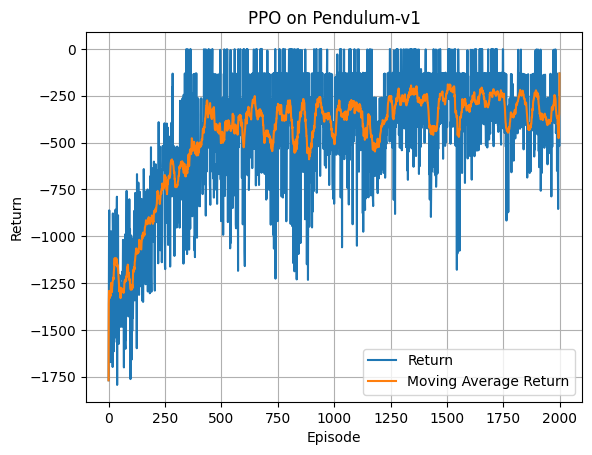

In [15]:
mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [16]:
score = rl_utils.moving_average_score(return_list, 10)
print(score)

-468.16850084854684


In [17]:
rl_utils.watch_agent(env_name, agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [18]:
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='ppo_pendulum(v1)_r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='ppo_pendulum(v1)_r10',
                                  score=score)

MoviePy - Building file ./video/ppo_pendulum(v1)_r1_score-468.17_20250501-055654.gif with imageio.


✅ Video saved at ./video/ppo_pendulum(v1)_r1_score-468.17_20250501-055654.gif
MoviePy - Building file ./video/ppo_pendulum(v1)_r10_score-468.17_20250501-055657.gif with imageio.


✅ Video saved at ./video/ppo_pendulum(v1)_r10_score-468.17_20250501-055657.gif


In [19]:
agent_dict = {
    'actor': agent.actor,
    'critic': agent.critic
}

rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='ppo_pendulum(v1)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/ppo_pendulum(v1)_score-468.17_20250501-055929.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/ppo_pendulum(v1)_score-468.17_20250501-055929_return_list.pkl
📈 Return curve saved at ./results/ppo_pendulum(v1)_score-468.17_20250501-055929_return_curve.png
